# TP — HealthMind (version finale v2)
**EDA → Nettoyage → Quartiles/IQR → Corrélation (Pearson & Spearman) → ACP (80%) → KMeans (Silhouette & Coude) → Profilage**
*(Commentaires pro + explication après chaque cellule)*

In [1]:
DATA_PATH = r"D:\codePack\OneDrive\Desktop\ProjectsClouds\MentallHealthAwareness\HealthMind_Mental_Health_Data_75k_MultiAlgo.csv"

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder, RobustScaler, StandardScaler,
    LabelEncoder, OrdinalEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import (
    train_test_split, cross_val_score,
    GridSearchCV, StratifiedKFold
)
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay
)

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)


# pd.set_option("display.max_columns", 200)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

%matplotlib inline


**Explication :** On fixe le chemin du fichier, on importe les librairies (imputation, encodage, scaling, ACP, KMeans, métriques) et on active l'affichage des graphiques.

## 1) Lecture & aperçu

In [2]:
df = pd.read_csv(DATA_PATH)
df = df.drop('User_ID', axis=1) 
print("Shape (lignes, colonnes):", df.shape)
display(df.head(5))
display(df.dtypes.to_frame("dtype"))
display(df.nunique().sort_values(ascending=False).to_frame("n_unique"))


Shape (lignes, colonnes): (75000, 13)


,Age,Gender,Education_Level,Employment_Status,Work_Hours_Week,Sleep_Hours_Night,Exercise_Freq_Week,Financial_Strain,Relationship_Quality,GAD-7_Score,PHQ-9_Score,Stress_Level_Scale,Risk_Level
0,18,Female,Ph.D.,NaN,51.97,8.21,4.00,1.24,10.00,4.00,8.00,2,Low
1,73,Male,Masters,Student,0.00,9.41,0.00,2.67,7.53,7.00,9.00,2,Low
2,40,Female,Masters,Employed,31.56,7.43,0.00,5.05,6.10,13.00,17.00,4,Low
3,38,Female,Masters,Student,0.00,5.14,2.00,4.24,6.76,12.00,14.00,3,Low
4,18,Male,Masters,Self-employed,49.31,7.16,NaN,4.87,8.83,12.00,13.00,3,Low


,dtype
Age,int64
Gender,object
Education_Level,object
Employment_Status,object
Work_Hours_Week,float64
Sleep_Hours_Night,float64
Exercise_Freq_Week,float64
Financial_Strain,float64
Relationship_Quality,float64
GAD-7_Score,float64


,n_unique
Relationship_Quality,69858
Sleep_Hours_Night,63372
Financial_Strain,61351
Work_Hours_Week,44161
Age,68
PHQ-9_Score,24
GAD-7_Score,18
Stress_Level_Scale,10
Exercise_Freq_Week,8
Employment_Status,5


**Explication :** On charge les données et on affiche un aperçu, les types et le nombre de valeurs uniques.

### 1.2 Valeurs manquantes & statistiques


Missing Values Summary:
                    Missing_Count  Missing_Pct
Education_Level             11250        15.00
Employment_Status           11250        15.00
Exercise_Freq_Week          11250        15.00
Sleep_Hours_Night           11240        14.99
Work_Hours_Week             11236        14.98
GAD-7_Score                  1716         2.29
PHQ-9_Score                  1716         2.29


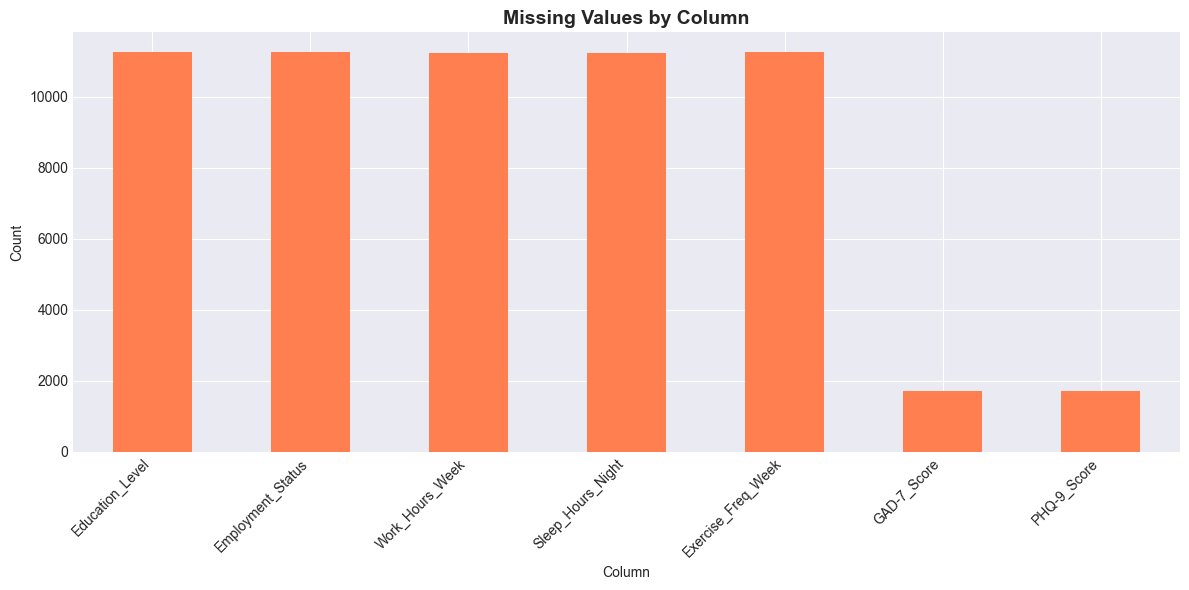


--------------------------------------------------------------------------------
Descriptive Statistics (Numerical Variables):
--------------------------------------------------------------------------------
                        count  mean   std    min   25%   50%   75%    max
Age                  75000.00 38.07 13.05  18.00 28.00 38.00 47.00  85.00
Work_Hours_Week      63764.00 35.05 25.68   0.00  0.00 43.12 54.37 249.00
Sleep_Hours_Night    63760.00  7.20  1.80   0.12  5.99  7.20  8.42  12.00
Exercise_Freq_Week   63750.00  3.51  2.29   0.00  2.00  4.00  5.00   7.00
Financial_Strain     75000.00  4.22  2.53   1.00  1.96  4.01  6.03  10.00
Relationship_Quality 75000.00  6.85  3.54 -99.00  5.65  6.99  8.34  10.00
GAD-7_Score          73284.00 10.94  4.41   4.00  7.00 10.00 14.00  21.00
PHQ-9_Score          73284.00 13.82  5.54   4.00  9.00 13.00 18.00  27.00
Stress_Level_Scale   75000.00  3.40  1.57   1.00  2.00  3.00  4.00  10.00

--------------------------------------------------

In [3]:
missing_count = df.isna().sum()
missing_pct = (df.isna().mean() * 100).round(2)
missing_table = pd.DataFrame({
    'Missing_Count': missing_count,
    'Missing_Pct': missing_pct
}).sort_values('Missing_Count', ascending=False)

print("\nMissing Values Summary:")
print(missing_table[missing_table['Missing_Count'] > 0])

if missing_count.sum() > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    missing_count[missing_count > 0].plot(kind='bar', ax=ax, color='coral')
    ax.set_title('Missing Values by Column', fontsize=14, fontweight='bold')
    ax.set_ylabel('Count')
    ax.set_xlabel('Column')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("✓ No missing values detected")

print("\n" + "-" * 80)
print("Descriptive Statistics (Numerical Variables):")
print("-" * 80)
print(df.describe().T)

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
if cat_cols:
    print("\n" + "-" * 80)
    print("Descriptive Statistics (Categorical Variables):")
    print("-" * 80)
    for col in cat_cols:
        print(f"\n{col}:")
        print(df[col].value_counts())
        print(f"  Unique values: {df[col].nunique()}")

**Explication :** On quantifie les manquants et on consulte les statistiques descriptives (min, max, quartiles).

### 1.3 Visualisations — distributions & outliers


Analyzing 9 numerical variables...


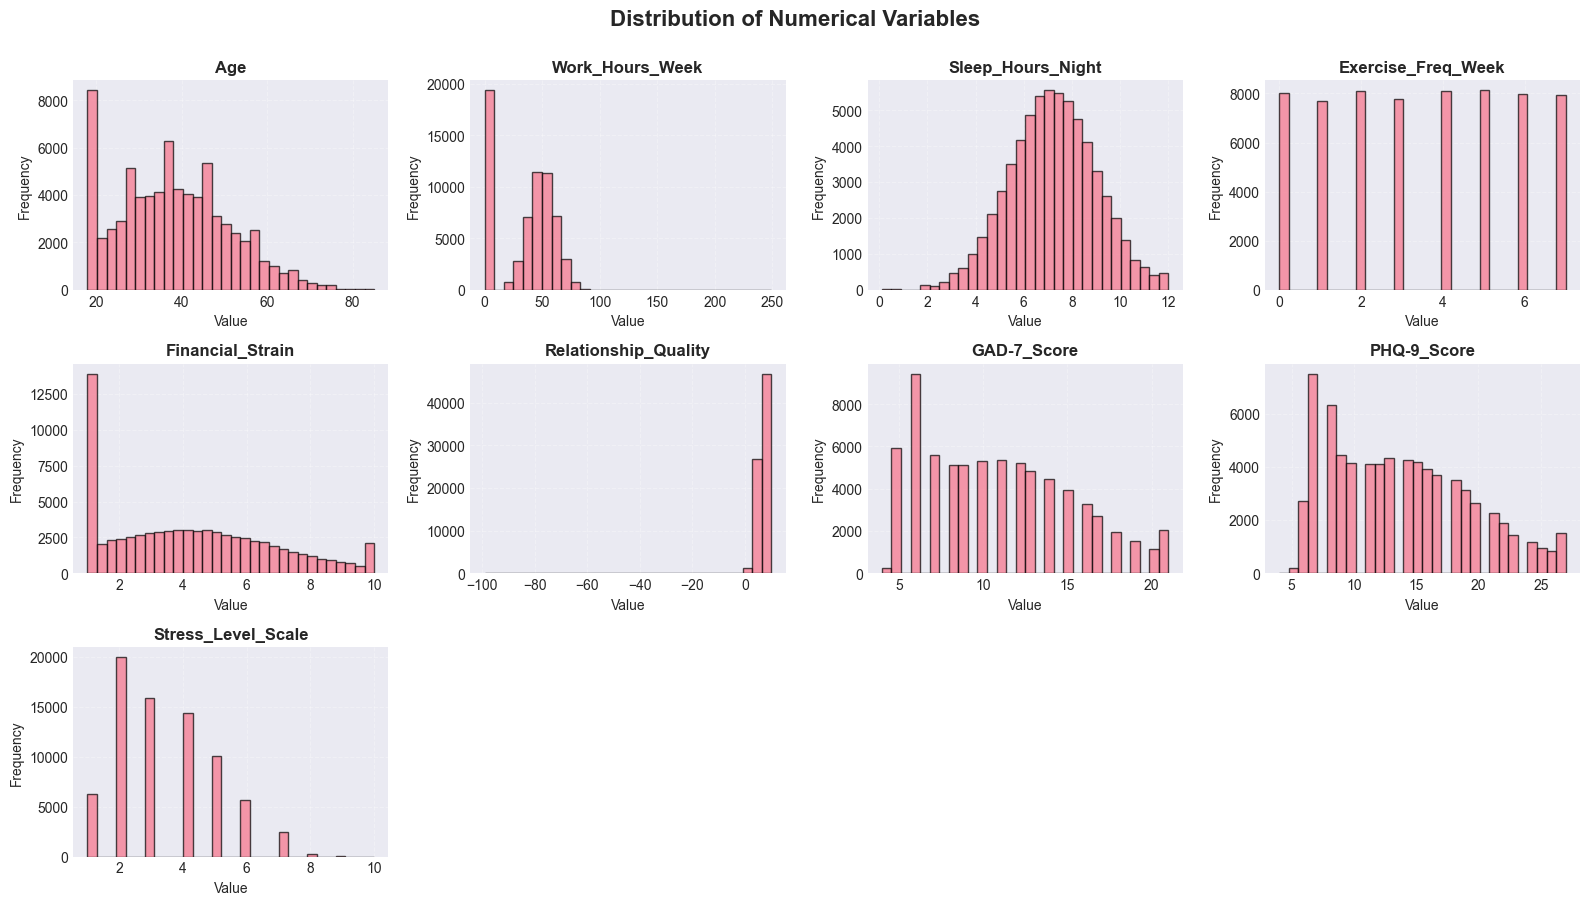

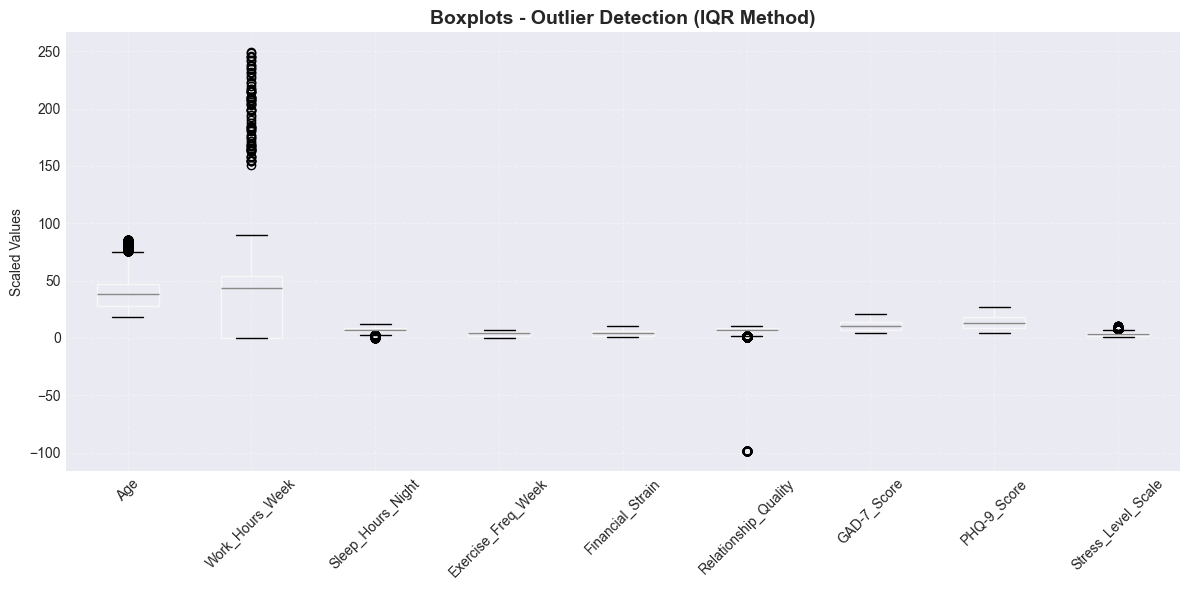


Distribution of Risk Levels:
Risk_Level
Low       55154
Medium    15798
High       4048
Name: count, dtype: int64

Percentages:
Risk_Level
Low      73.54
Medium   21.06
High      5.40
Name: count, dtype: float64


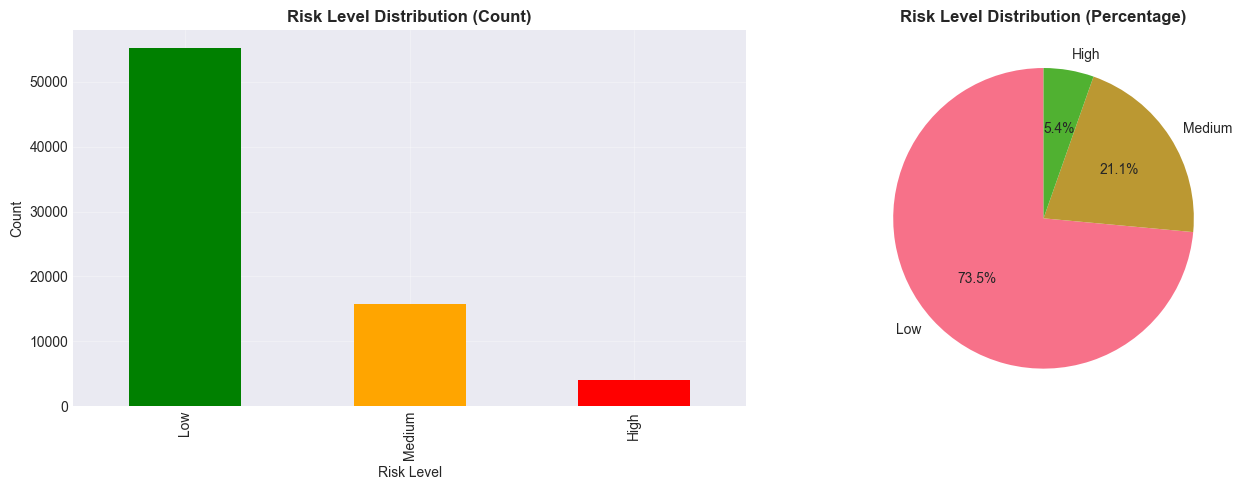

In [4]:
num_cols_all = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'User_ID' in num_cols_all:
    num_cols_all.remove('User_ID')

print(f"\nAnalyzing {len(num_cols_all)} numerical variables...")

n_cols = len(num_cols_all)
n_plot_cols = 4
n_rows = int(np.ceil(n_cols / n_plot_cols))

if n_cols > 0:
    fig, axes = plt.subplots(n_rows, n_plot_cols, figsize=(n_plot_cols * 4, n_rows * 3))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

    for i, col in enumerate(num_cols_all):
        axes[i].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
        axes[i].set_title(f'{col}', fontweight='bold')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, linestyle='--', alpha=0.3)

    for i in range(n_cols, len(axes)):
        axes[i].axis('off')

    plt.suptitle('Distribution of Numerical Variables', fontsize=16, fontweight='bold', y=1.001)
    plt.tight_layout()
    plt.show()

if n_cols > 0:
    fig, ax = plt.subplots(figsize=(max(12, len(num_cols_all) * 0.8), 6))
    df[num_cols_all].boxplot(ax=ax, rot=45)
    ax.set_title('Boxplots - Outlier Detection (IQR Method)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Scaled Values')
    ax.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

if 'Risk_Level' in df.columns:
    print("\nDistribution of Risk Levels:")
    risk_counts = df['Risk_Level'].value_counts()
    print(risk_counts)
    print(f"\nPercentages:")
    print((risk_counts / len(df) * 100).round(2))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    risk_counts.plot(kind='bar', ax=ax1, color=['green', 'orange', 'red'])
    ax1.set_title('Risk Level Distribution (Count)', fontweight='bold')
    ax1.set_xlabel('Risk Level')
    ax1.set_ylabel('Count')
    ax1.grid(True, alpha=0.3)

    risk_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Risk Level Distribution (Percentage)', fontweight='bold')
    ax2.set_ylabel('')

    plt.tight_layout()
    plt.show()

**Explication :** Histogrammes = forme; boxplots = outliers; carte des manquants = pattern de NaN.

## 2) Quartiles & IQR — détection systématique des outliers


IQR Outlier Detection Summary:
               Variable    Q1  Median    Q3   IQR  Lower_Bound  Upper_Bound  Outliers_Count  Outliers_Pct
5  Relationship_Quality  5.65    6.99  8.34  2.68         1.62        12.36             345          0.46
2     Sleep_Hours_Night  5.99    7.20  8.42  2.43         2.34        12.07             275          0.43
8    Stress_Level_Scale  2.00    3.00  4.00  2.00        -1.00         7.00             257          0.34
0                   Age 28.00   38.00 47.00 19.00        -0.50        75.50             222          0.30
1       Work_Hours_Week  0.00   43.12 54.37 54.37       -81.55       135.91              75          0.12
3    Exercise_Freq_Week  2.00    4.00  5.00  3.00        -2.50         9.50               0          0.00
4      Financial_Strain  1.96    4.01  6.03  4.06        -4.13        12.12               0          0.00
6           GAD-7_Score  7.00   10.00 14.00  7.00        -3.50        24.50               0          0.00
7           PH

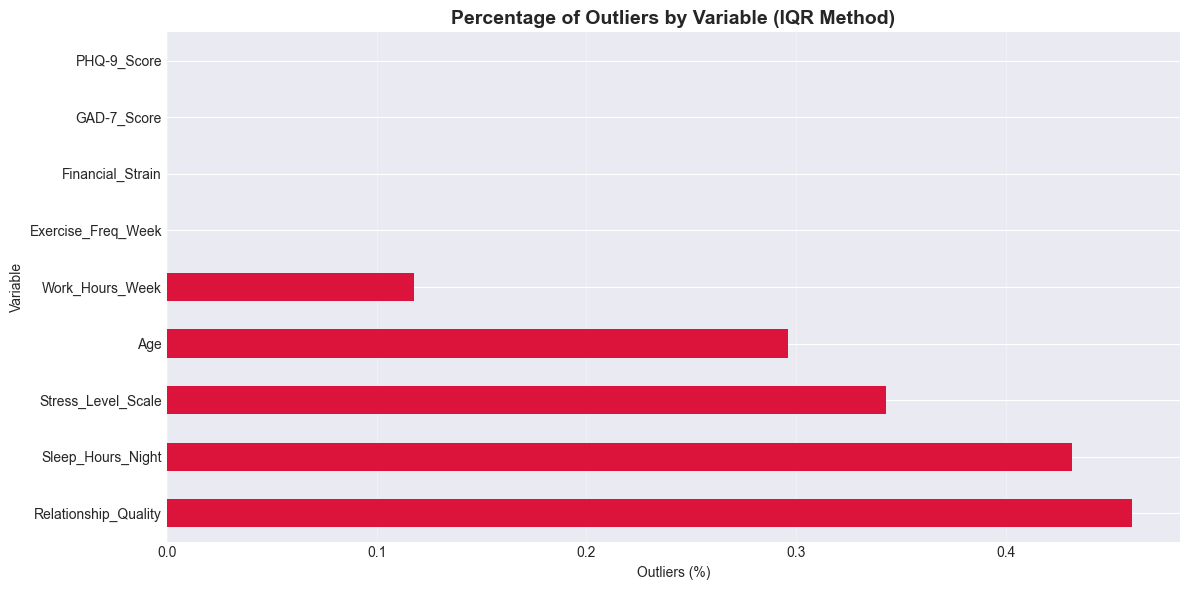

In [5]:
iqr_report = []

for col in num_cols_all:
    s = df[col].dropna()
    if len(s) == 0:
        continue

    Q1 = s.quantile(0.25)
    Q2 = s.quantile(0.50)  
    Q3 = s.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = ((s < lower_bound) | (s > upper_bound))
    outlier_count = int(outliers.sum())
    outlier_pct = (outlier_count / len(s) * 100)

    iqr_report.append({
        'Variable': col,
        'Q1': Q1,
        'Median': Q2,
        'Q3': Q3,
        'IQR': IQR,
        'Lower_Bound': lower_bound,
        'Upper_Bound': upper_bound,
        'Outliers_Count': outlier_count,
        'Outliers_Pct': outlier_pct
    })

iqr_df = pd.DataFrame(iqr_report).sort_values('Outliers_Count', ascending=False)
print("\nIQR Outlier Detection Summary:")
print(iqr_df.to_string())

fig, ax = plt.subplots(figsize=(12, 6))
iqr_df.plot(x='Variable', y='Outliers_Pct', kind='barh', ax=ax, color='crimson', legend=False)
ax.set_title('Percentage of Outliers by Variable (IQR Method)', fontsize=14, fontweight='bold')
ax.set_xlabel('Outliers (%)')
ax.set_ylabel('Variable')
ax.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


**Explication :** On calcule Q1, médiane, Q3, IQR et les bornes. On compte les outliers par variable.

## 3) Nettoyage — doublons, clipping métier, imputation

In [6]:
n_before = len(df)
df = df.drop_duplicates(ignore_index=True)
n_after = len(df)
n_duplicates = n_before - n_after
print(f"\n✓ Duplicates removed: {n_duplicates:,} rows ({n_duplicates/n_before*100:.2f}%)")
print(f"  Remaining rows: {n_after:,}")

print("\n" + "-" * 80)
print("Applying Business Rules (Clipping):")
print("-" * 80)

rules_clip = {
    "Work_Hours_Week": (0, 100),     
    "Sleep_Hours_Night": (0, 12),    
    "Exercise_Freq_Week": (0, 7),    
    "Stress_Level_Scale": (1, 8),    
    "Age": (16, 80),                 
}

for col, (lo, hi) in rules_clip.items():
    if col in df.columns:
        n_clipped = ((df[col] < lo) | (df[col] > hi)).sum()
        if n_clipped > 0:
            print(f"  {col}: {n_clipped} values clipped to [{lo}, {hi}]")
            df[col] = df[col].clip(lower=lo, upper=hi)
        else:
            print(f"  {col}: ✓ All values within [{lo}, {hi}]")


if 'Sleep_Hours_Night' in df.columns:
    n_invalid = (df['Sleep_Hours_Night'] < 0).sum()
    if n_invalid > 0:
        df.loc[df['Sleep_Hours_Night'] < 0, 'Sleep_Hours_Night'] = np.nan
        print(f"  Sleep_Hours_Night: {n_invalid} negative values set to NaN")

if 'Exercise_Freq_Week' in df.columns:
    n_invalid = (df['Exercise_Freq_Week'] > 7).sum()
    if n_invalid > 0:
        df.loc[df['Exercise_Freq_Week'] > 7, 'Exercise_Freq_Week'] = np.nan
        print(f"  Exercise_Freq_Week: {n_invalid} values > 7 set to NaN")

print("\n" + "-" * 80)
print("Imputation of Missing Values:")
print("-" * 80)

num_cols = df.select_dtypes(include='number').columns.tolist()
cat_cols = df.select_dtypes(exclude='number').columns.tolist()

if 'User_ID' in num_cols:
    num_cols.remove('User_ID')

if num_cols:
    imputer_num = SimpleImputer(strategy='median')
    df[num_cols] = imputer_num.fit_transform(df[num_cols])
    print(f"✓ Numerical columns imputed with median: {len(num_cols)} columns")

if cat_cols:
    imputer_cat = SimpleImputer(strategy='most_frequent')
    df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])
    print(f"✓ Categorical columns imputed with mode: {len(cat_cols)} columns")

n_missing = df.isna().sum().sum()
print(f"\n✓ Total missing values remaining: {n_missing}")



✓ Duplicates removed: 0 rows (0.00%)
  Remaining rows: 75,000

--------------------------------------------------------------------------------
Applying Business Rules (Clipping):
--------------------------------------------------------------------------------
  Work_Hours_Week: 75 values clipped to [0, 100]
  Sleep_Hours_Night: ✓ All values within [0, 12]
  Exercise_Freq_Week: ✓ All values within [0, 7]
  Stress_Level_Scale: 31 values clipped to [1, 8]
  Age: 76 values clipped to [16, 80]

--------------------------------------------------------------------------------
Imputation of Missing Values:
--------------------------------------------------------------------------------
✓ Numerical columns imputed with median: 9 columns
✓ Categorical columns imputed with mode: 4 columns

✓ Total missing values remaining: 0


**Explication :** Doublons retirés, clipping (valeurs impossibles), imputation (médiane/mode).

## 4) Corrélation — Pearson & Spearman (sur X sans ID/étiquette)


Analyzing correlations for 9 numerical features...


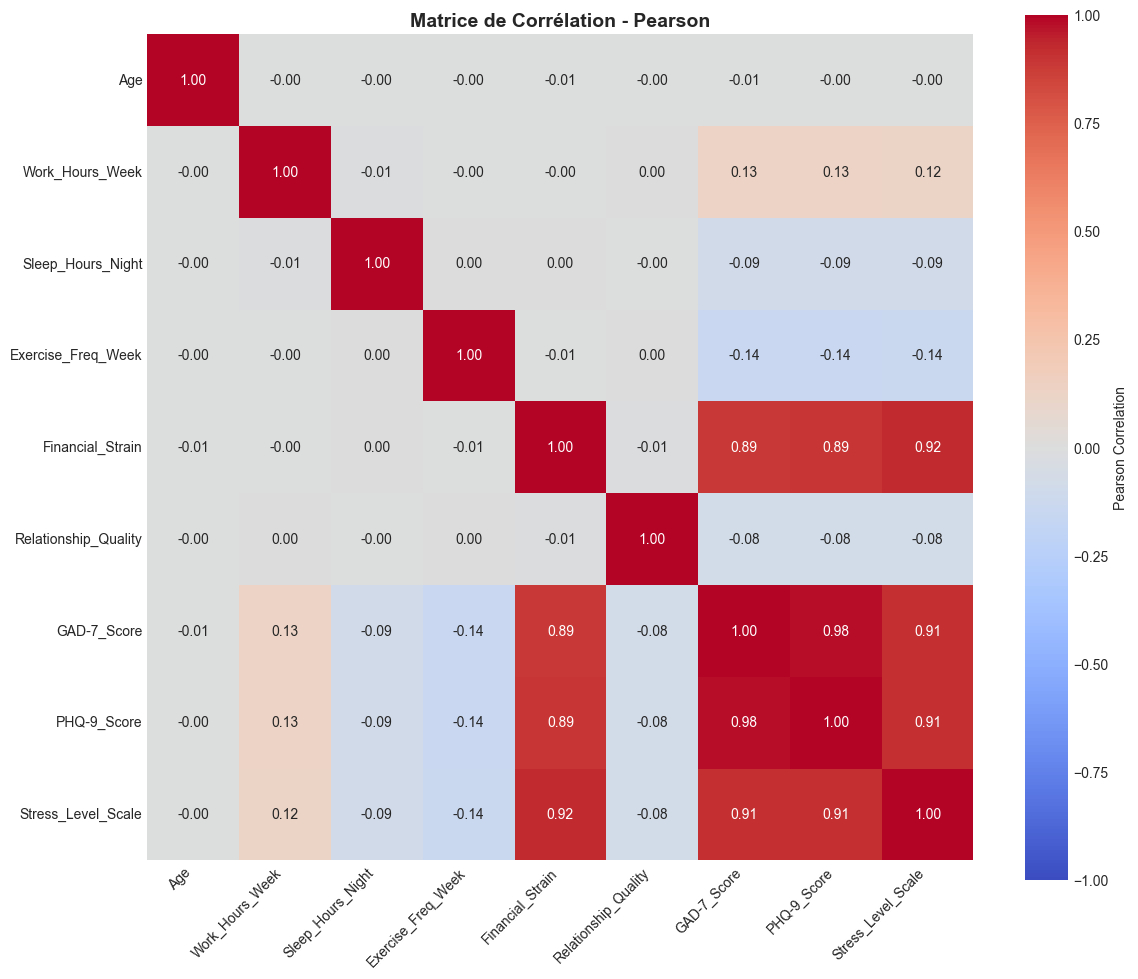


Top correlations (Spearman) with Stress_Level_Scale:
Stress_Level_Scale     1.00
PHQ-9_Score            0.93
GAD-7_Score            0.93
Financial_Strain       0.92
Exercise_Freq_Week     0.14
Work_Hours_Week        0.12
Relationship_Quality   0.11
Sleep_Hours_Night      0.08
Age                    0.00
Name: Stress_Level_Scale, dtype: float64

Top correlations (Spearman) with GAD-7_Score:
GAD-7_Score            1.00
PHQ-9_Score            0.98
Stress_Level_Scale     0.93
Financial_Strain       0.90
Exercise_Freq_Week     0.14
Work_Hours_Week        0.12
Relationship_Quality   0.12
Sleep_Hours_Night      0.09
Age                    0.01
Name: GAD-7_Score, dtype: float64

Top correlations (Spearman) with PHQ-9_Score:
PHQ-9_Score            1.00
GAD-7_Score            0.98
Stress_Level_Scale     0.93
Financial_Strain       0.91
Exercise_Freq_Week     0.14
Work_Hours_Week        0.12
Relationship_Quality   0.12
Sleep_Hours_Night      0.09
Age                    0.01
Name: PHQ-9_Score, dt

In [7]:
drop_cols = []
if 'User_ID' in df.columns:
    drop_cols.append('User_ID')
if 'Risk_Level' in df.columns:
    drop_cols.append('Risk_Level')

X = df.drop(columns=drop_cols, errors='ignore')
num_only = X.select_dtypes(include=['int64', 'float64']).copy()

print(f"\nAnalyzing correlations for {num_only.shape[1]} numerical features...")

corr_pearson = num_only.corr(method='pearson')

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    corr_pearson,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    cbar_kws={'label': 'Pearson Correlation'},
    ax=ax
)
ax.set_title('Matrice de Corrélation - Pearson', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

corr_spearman = num_only.corr(method='spearman')

key_vars = ['Stress_Level_Scale', 'GAD-7_Score', 'PHQ-9_Score']
for var in key_vars:
    if var in corr_spearman.columns:
        print(f"\nTop correlations (Spearman) with {var}:")
        print(corr_spearman[var].abs().sort_values(ascending=False).head(10))

print("\n" + "-" * 80)
print("Highly Correlated Feature Pairs (|r| > 0.8):")
print("-" * 80)

high_corr_pairs = []
for i in range(len(corr_pearson.columns)):
    for j in range(i+1, len(corr_pearson.columns)):
        if abs(corr_pearson.iloc[i, j]) > 0.8:
            high_corr_pairs.append({
                'Var1': corr_pearson.columns[i],
                'Var2': corr_pearson.columns[j],
                'Correlation': corr_pearson.iloc[i, j]
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False)
    print(high_corr_df)
else:
    print("✓ No highly correlated pairs found (threshold: |r| > 0.8)")


**Explication :** Pearson (linéaire) et Spearman (monotone) sur les numériques de X, après exclusion de `User_ID`/`Risk_Level`. 

## 5) Préparation (RobustScaler + OneHot) sur X

In [9]:
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

print(f"\nNumerical features: {len(num_features)}")
print(f"Categorical features: {len(cat_features)}")

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())  
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

X_preprocessed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()

print(f"\n✓ Preprocessing complete:")
print(f"  Original features: {X.shape[1]}")
print(f"  Preprocessed features: {X_preprocessed.shape[1]}")
print(f"  Shape: {X_preprocessed.shape}")



Numerical features: 9
Categorical features: 3

✓ Preprocessing complete:
  Original features: 12
  Preprocessed features: 22
  Shape: (75000, 22)


**Explication :** Pipeline propre et reproductible pour préparer les features.

## 6) ACP — objectif 80% de variance cumulée


PCA Results:
  Components for 80% variance: 7
  Cumulative variance explained: 83.00%


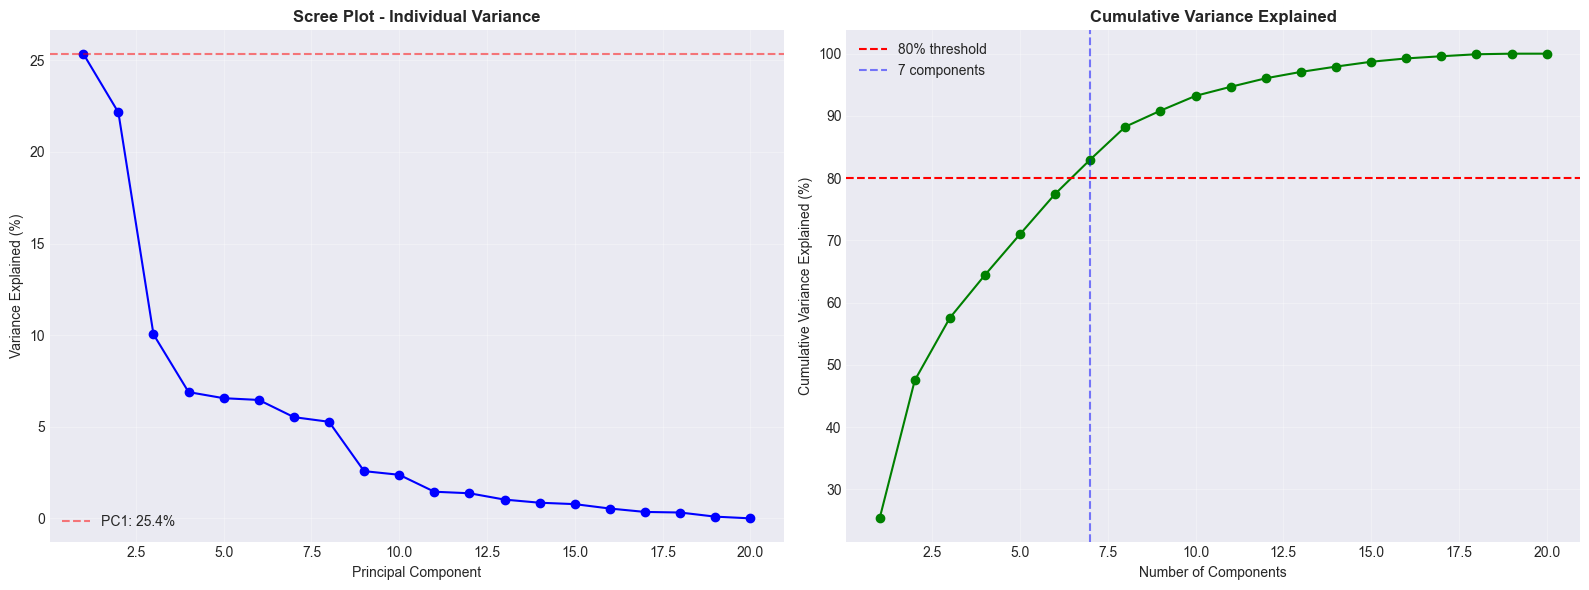


Final PCA shape: (75000, 7)
Variance by component (%):
  PC1: 25.36%
  PC2: 22.16%
  PC3: 10.04%
  PC4: 6.89%
  PC5: 6.56%
  PC6: 6.46%
  PC7: 5.52%


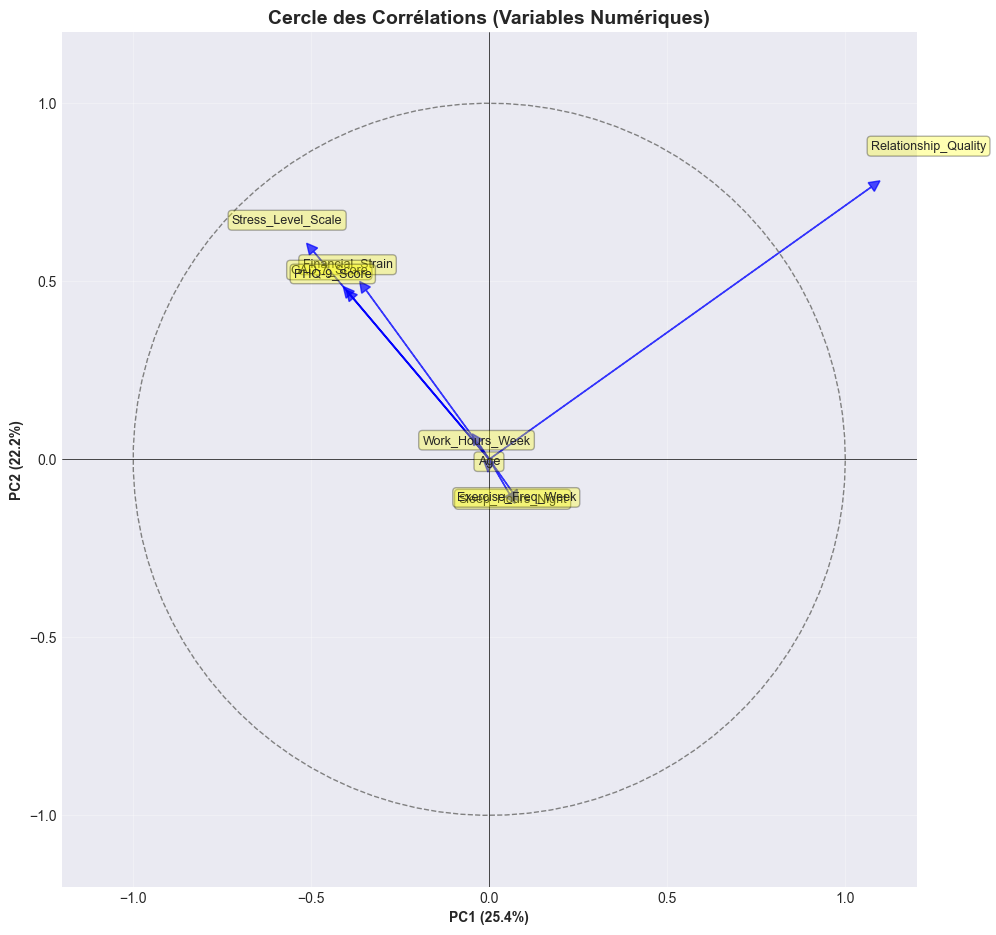

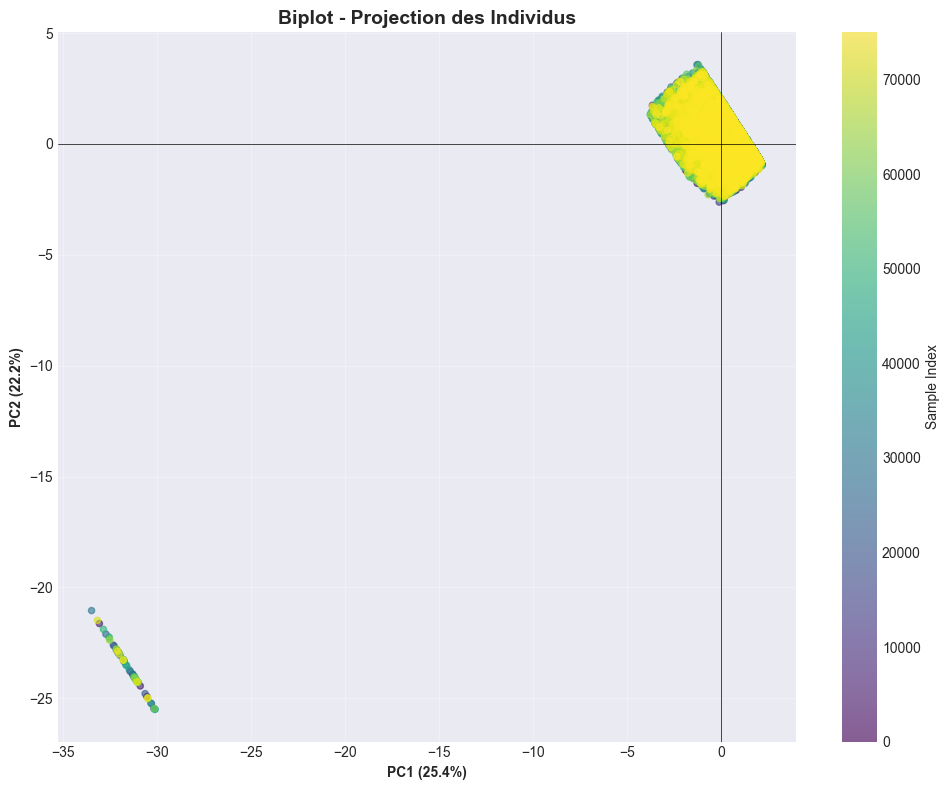

In [10]:
n_components_max = min(20, X_preprocessed.shape[1], X_preprocessed.shape[0])
pca_init = PCA(n_components=n_components_max, random_state=RANDOM_STATE)
Z_init = pca_init.fit_transform(X_preprocessed)

explained_variance = pca_init.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1
if cumulative_variance[-1] < 0.80:
    n_components_80 = len(cumulative_variance)

print(f"\nPCA Results:")
print(f"  Components for 80% variance: {n_components_80}")
print(f"  Cumulative variance explained: {cumulative_variance[n_components_80-1]*100:.2f}%")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(range(1, len(explained_variance) + 1), explained_variance * 100, 'bo-')
ax1.axhline(y=explained_variance[0] * 100, color='r', linestyle='--', alpha=0.5,
            label=f'PC1: {explained_variance[0]*100:.1f}%')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Variance Explained (%)')
ax1.set_title('Scree Plot - Individual Variance', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, 'go-')
ax2.axhline(y=80, color='r', linestyle='--', label='80% threshold')
ax2.axvline(x=n_components_80, color='b', linestyle='--', alpha=0.5,
            label=f'{n_components_80} components')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Variance Explained (%)')
ax2.set_title('Cumulative Variance Explained', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

pca_final = PCA(n_components=n_components_80, random_state=RANDOM_STATE)
Z = pca_final.fit_transform(X_preprocessed)

print(f"\nFinal PCA shape: {Z.shape}")
print(f"Variance by component (%):")
for i, var in enumerate(pca_final.explained_variance_ratio_):
    print(f"  PC{i+1}: {var*100:.2f}%")

import re
loadings = pca_final.components_.T * np.sqrt(pca_final.explained_variance_)

num_feature_names = [re.sub(r'^num__', '', f) for f in feature_names if f.startswith('num__')]
num_loadings = loadings[[f.startswith('num__') for f in feature_names]]

fig, ax = plt.subplots(figsize=(10, 10))

theta = np.linspace(0, 2 * np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), '--', color='gray', linewidth=1)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)

for name, (x, y) in zip(num_feature_names, num_loadings[:, :2]):
    ax.arrow(0, 0, x, y, head_width=0.03, head_length=0.03,
             fc='blue', ec='blue', alpha=0.7)
    ax.text(x * 1.15, y * 1.15, name, ha='center', va='center',
            fontsize=9, bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]*100:.1f}%)', fontweight='bold')
ax.set_ylabel(f'PC2 ({pca_final.explained_variance_ratio_[1]*100:.1f}%)', fontweight='bold')
ax.set_title('Cercle des Corrélations (Variables Numériques)', fontsize=14, fontweight='bold')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(Z[:, 0], Z[:, 1], s=20, alpha=0.6, c=range(len(Z)), cmap='viridis')
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]*100:.1f}%)', fontweight='bold')
ax.set_ylabel(f'PC2 ({pca_final.explained_variance_ratio_[1]*100:.1f}%)', fontweight='bold')
ax.set_title('Biplot - Projection des Individus', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Sample Index')
plt.tight_layout()
plt.show()


**Explication :** On atteint ~80% de variance, cercle des corrélations et biplot pour interpréter les axes.

## 7) CLUSTERING - KMEANS & DBSCAN

## 7.1: K-MEANS CLUSTERING

k=2: Silhouette Score = 0.9254
k=3: Silhouette Score = 0.2284
k=4: Silhouette Score = 0.1359
k=5: Silhouette Score = 0.1243
k=6: Silhouette Score = 0.1181
k=7: Silhouette Score = 0.1189
k=8: Silhouette Score = 0.1134

✓ Best k = 2 (Silhouette = 0.9254)


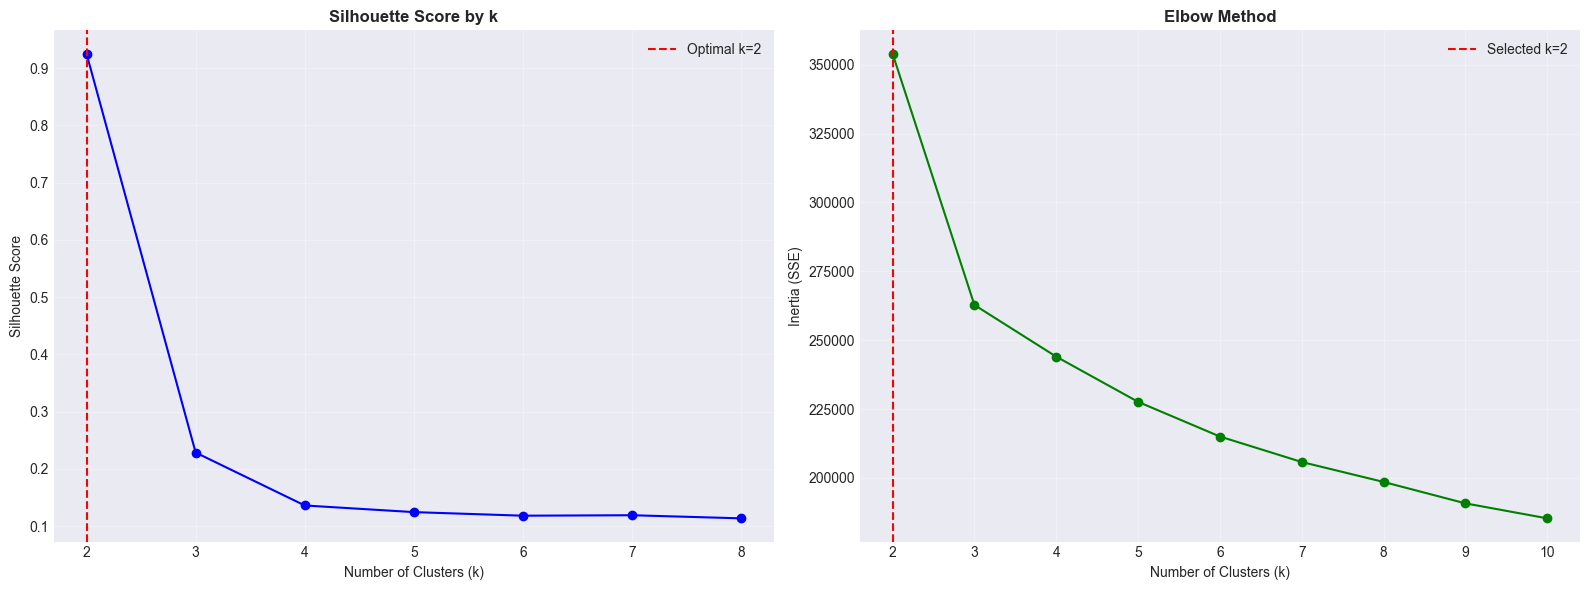

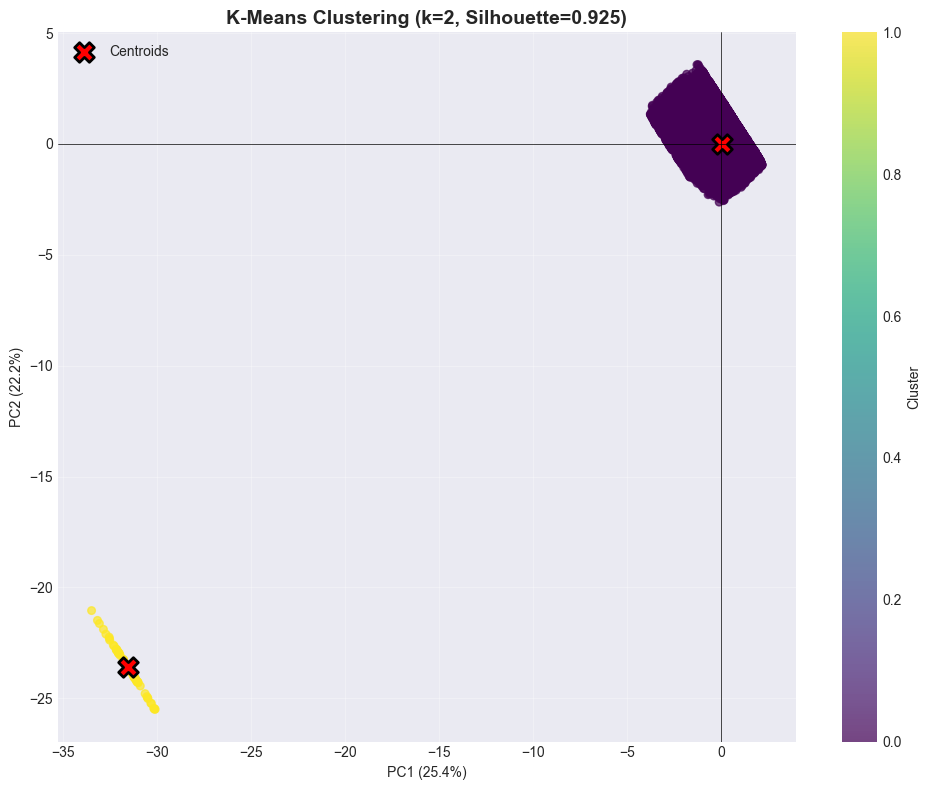


K-Means Cluster Sizes:
KMeans_Cluster
0    74940
1       60
Name: count, dtype: int64

Percentages:
KMeans_Cluster
0   99.92
1    0.08
Name: count, dtype: float64

Cluster Profiles (Numerical - Means):
                 Age  Work_Hours_Week  Sleep_Hours_Night  Exercise_Freq_Week  \
KMeans_Cluster                                                                 
0              38.06            36.16               7.20                3.58   
1              38.33            33.49               7.47                3.57   

                Financial_Strain  Relationship_Quality  GAD-7_Score  \
KMeans_Cluster                                                        
0                           4.22                  6.94        10.92   
1                           5.13                -99.00        11.95   

                PHQ-9_Score  Stress_Level_Scale  
KMeans_Cluster                                   
0                     13.80                3.40  
1                     15.00              

In [11]:
silhouette_scores = []
k_range = range(2, 9)

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=RANDOM_STATE)
    labels = kmeans.fit_predict(Z)
    score = silhouette_score(Z, labels)
    silhouette_scores.append((k, score))
    print(f"k={k}: Silhouette Score = {score:.4f}")

best_k, best_silhouette = max(silhouette_scores, key=lambda x: x[1])
print(f"\n✓ Best k = {best_k} (Silhouette = {best_silhouette:.4f})")

inertias = []
k_range_elbow = range(2, 11)
for k in k_range_elbow:
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=RANDOM_STATE)
    kmeans.fit(Z)
    inertias.append(kmeans.inertia_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot([x[0] for x in silhouette_scores], [x[1] for x in silhouette_scores], 'bo-')
ax1.axvline(x=best_k, color='r', linestyle='--', label=f'Optimal k={best_k}')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Silhouette Score')
ax1.set_title('Silhouette Score by k', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(k_range_elbow, inertias, 'go-')
ax2.axvline(x=best_k, color='r', linestyle='--', label=f'Selected k={best_k}')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Inertia (SSE)')
ax2.set_title('Elbow Method', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

kmeans_final = KMeans(n_clusters=best_k, n_init=20, random_state=RANDOM_STATE)
kmeans_labels = kmeans_final.fit_predict(Z)

fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(Z[:, 0], Z[:, 1], c=kmeans_labels, s=30, cmap='viridis', alpha=0.7)
centroids = kmeans_final.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X',
           edgecolors='black', linewidths=2, label='Centroids')
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca_final.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title(f'K-Means Clustering (k={best_k}, Silhouette={best_silhouette:.3f})',
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Cluster')
plt.tight_layout()
plt.show()

df_profiling = df.copy()
df_profiling['KMeans_Cluster'] = kmeans_labels

print(f"\nK-Means Cluster Sizes:")
cluster_sizes = df_profiling['KMeans_Cluster'].value_counts().sort_index()
print(cluster_sizes)
print(f"\nPercentages:")
print((cluster_sizes / len(df_profiling) * 100).round(2))

num_cols_profile = df.select_dtypes(include=[np.number]).columns.tolist()
if 'User_ID' in num_cols_profile:
    num_cols_profile.remove('User_ID')

profile_means = df_profiling.groupby('KMeans_Cluster')[num_cols_profile].mean().round(2)
print("\nCluster Profiles (Numerical - Means):")
print(profile_means)

cat_cols_profile = df.select_dtypes(exclude=[np.number]).columns.tolist()
if cat_cols_profile:
    print("\nCluster Profiles (Categorical - Modes):")
    profile_modes = df_profiling.groupby('KMeans_Cluster')[cat_cols_profile].agg(
        lambda x: x.mode()[0] if len(x.mode()) > 0 else np.nan
    )
    print(profile_modes)

**Explication :** Choix de k avec silhouette + coude, carte des clusters, et profilage (moyennes & modes).

## 7.2: DBSCAN CLUSTERING

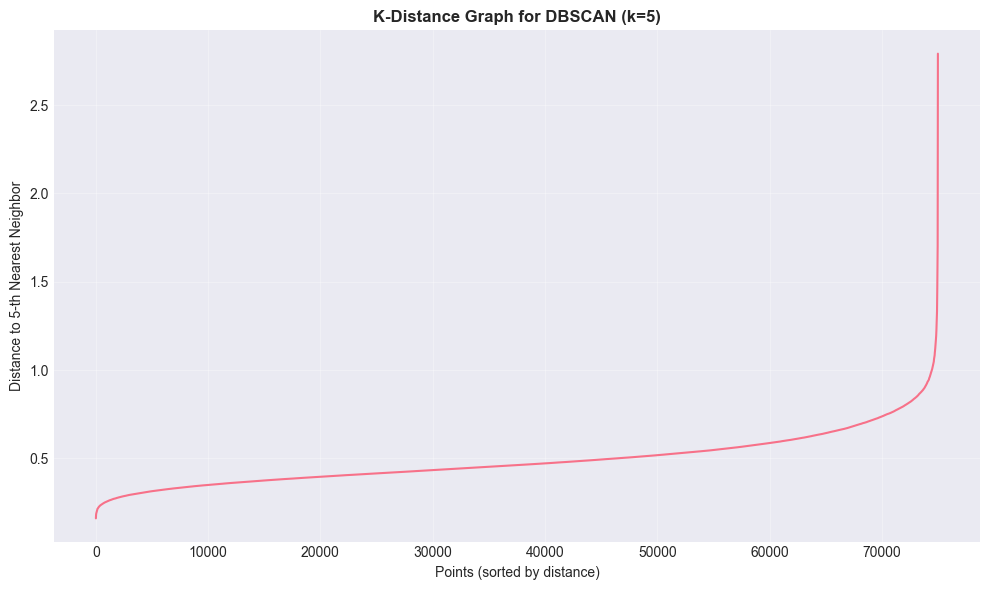

Suggested eps (90th percentile): 0.68

DBSCAN Results (eps=0.68, min_samples=8):
  Clusters found: 21
  Noise points: 5667 (7.6%)
  Silhouette Score: -0.2718


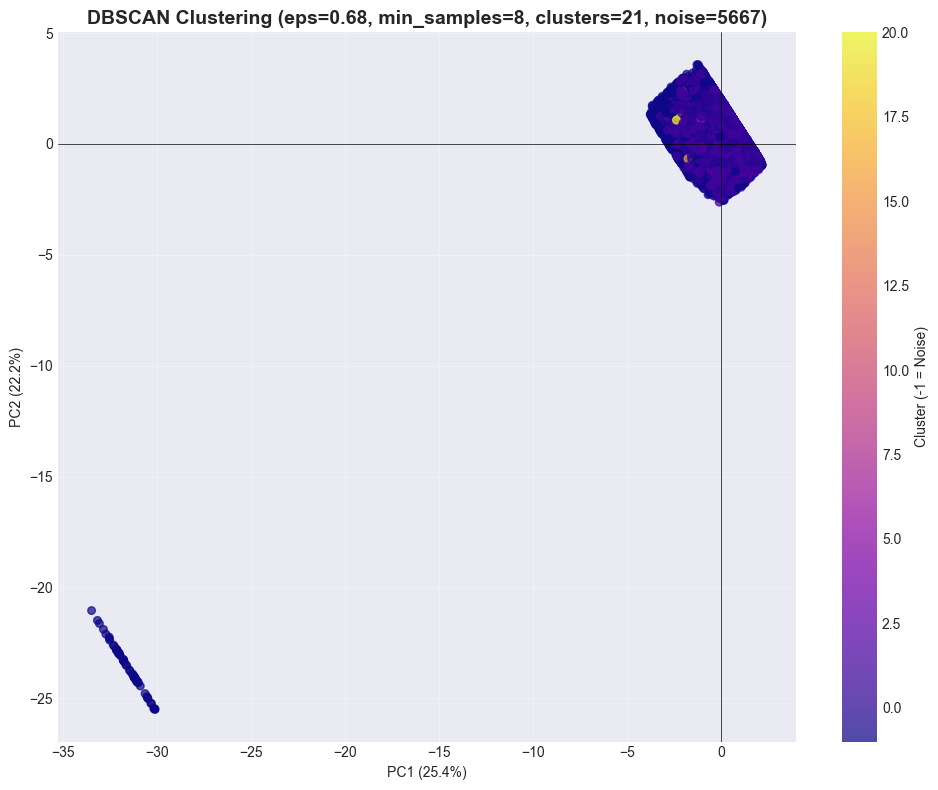

In [12]:
k_neighbors = 5
nbrs = NearestNeighbors(n_neighbors=k_neighbors)
nbrs.fit(Z)
distances, indices = nbrs.kneighbors(Z)
distances = np.sort(distances[:, k_neighbors-1])

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(distances)
ax.set_xlabel('Points (sorted by distance)')
ax.set_ylabel(f'Distance to {k_neighbors}-th Nearest Neighbor')
ax.set_title(f'K-Distance Graph for DBSCAN (k={k_neighbors})', fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

eps_suggestion = np.percentile(distances, 90)  # 90th percentile
print(f"Suggested eps (90th percentile): {eps_suggestion:.2f}")

eps = eps_suggestion
min_samples = 8

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(Z)

n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"\nDBSCAN Results (eps={eps:.2f}, min_samples={min_samples}):")
print(f"  Clusters found: {n_clusters_dbscan}")
print(f"  Noise points: {n_noise} ({n_noise/len(dbscan_labels)*100:.1f}%)")

if n_clusters_dbscan > 1:
    mask = dbscan_labels != -1
    if mask.sum() > 0:
        dbscan_silhouette = silhouette_score(Z[mask], dbscan_labels[mask])
        print(f"  Silhouette Score: {dbscan_silhouette:.4f}")
else:
    print("  Silhouette Score: N/A (< 2 clusters)")

fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(Z[:, 0], Z[:, 1], c=dbscan_labels, s=30, cmap='plasma', alpha=0.7)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca_final.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title(f'DBSCAN Clustering (eps={eps:.2f}, min_samples={min_samples}, '
             f'clusters={n_clusters_dbscan}, noise={n_noise})',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Cluster (-1 = Noise)')
plt.tight_layout()
plt.show()

## 7.3: K-MEANS VS DBSCAN COMPARISON 

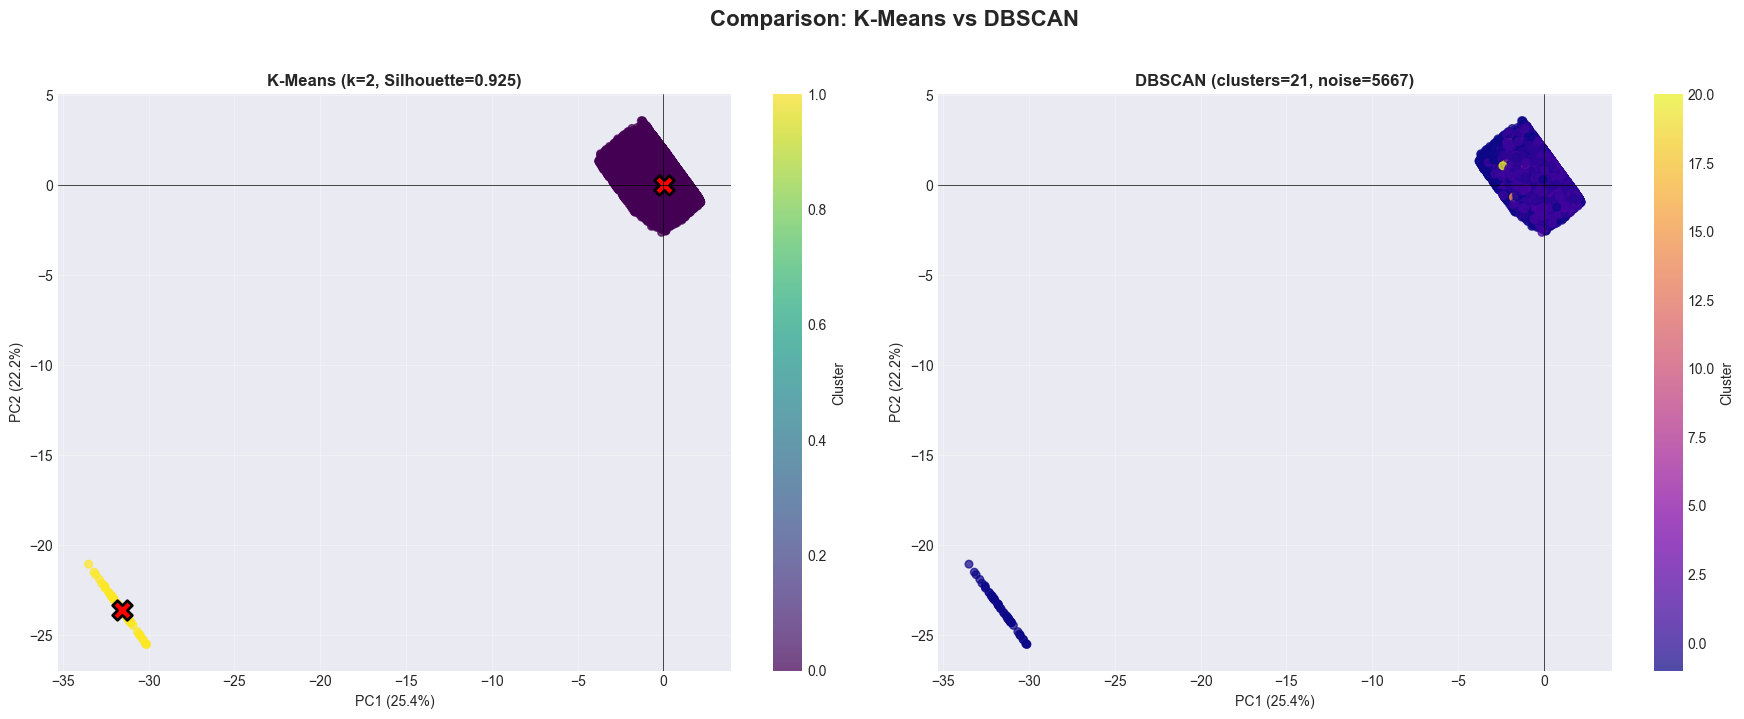

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

scatter1 = ax1.scatter(Z[:, 0], Z[:, 1], c=kmeans_labels, s=30, cmap='viridis', alpha=0.7)
ax1.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X',
            edgecolors='black', linewidths=2)
ax1.axhline(0, color='black', linewidth=0.5)
ax1.axvline(0, color='black', linewidth=0.5)
ax1.set_xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]*100:.1f}%)')
ax1.set_ylabel(f'PC2 ({pca_final.explained_variance_ratio_[1]*100:.1f}%)')
ax1.set_title(f'K-Means (k={best_k}, Silhouette={best_silhouette:.3f})', fontweight='bold')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=ax1, label='Cluster')

scatter2 = ax2.scatter(Z[:, 0], Z[:, 1], c=dbscan_labels, s=30, cmap='plasma', alpha=0.7)
ax2.axhline(0, color='black', linewidth=0.5)
ax2.axvline(0, color='black', linewidth=0.5)
ax2.set_xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]*100:.1f}%)')
ax2.set_ylabel(f'PC2 ({pca_final.explained_variance_ratio_[1]*100:.1f}%)')
ax2.set_title(f'DBSCAN (clusters={n_clusters_dbscan}, noise={n_noise})', fontweight='bold')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax2, label='Cluster')

plt.suptitle('Comparison: K-Means vs DBSCAN', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


# 8) CLASSIFICATION MODELS (DECISION TREE, RANDOM FOREST, SVM, XGBOOST)

In [14]:
if 'Risk_Level' not in df.columns:
    print("\n⚠ Warning: Risk_Level column not found. Skipping classification...")
else:
    y = df['Risk_Level'].copy()

    if y.dtype == 'object':
        le_target = LabelEncoder()
        y_encoded = le_target.fit_transform(y)
        target_classes = le_target.classes_
    else:
        y_encoded = y.values
        target_classes = np.unique(y_encoded)

    print(f"\nTarget variable: Risk_Level")
    print(f"Classes: {target_classes}")
    print(f"Distribution:")
    print(pd.Series(y).value_counts().sort_index())

    X_train, X_test, y_train, y_test = train_test_split(
        X_preprocessed, y_encoded,
        test_size=0.2,
        random_state=RANDOM_STATE,
        stratify=y_encoded
    )

    print(f"\nTrain set: {X_train.shape[0]:,} samples")
    print(f"Test set: {X_test.shape[0]:,} samples")

    model_results = {}


Target variable: Risk_Level
Classes: ['High' 'Low' 'Medium']
Distribution:
Risk_Level
High       4048
Low       55154
Medium    15798
Name: count, dtype: int64

Train set: 60,000 samples
Test set: 15,000 samples


## 8.1: DECISION TREE


Decision Tree Results:
  Accuracy: 0.9504
  F1-Score (weighted): 0.9509

Classification Report:
              precision    recall  f1-score   support

        High       0.86      0.86      0.86       809
         Low       0.98      0.97      0.98     11031
      Medium       0.86      0.91      0.89      3160

    accuracy                           0.95     15000
   macro avg       0.90      0.91      0.91     15000
weighted avg       0.95      0.95      0.95     15000



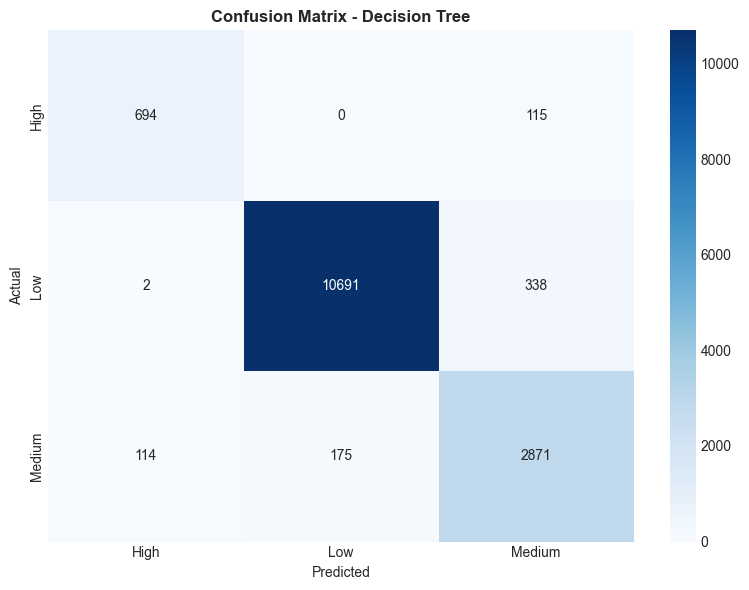

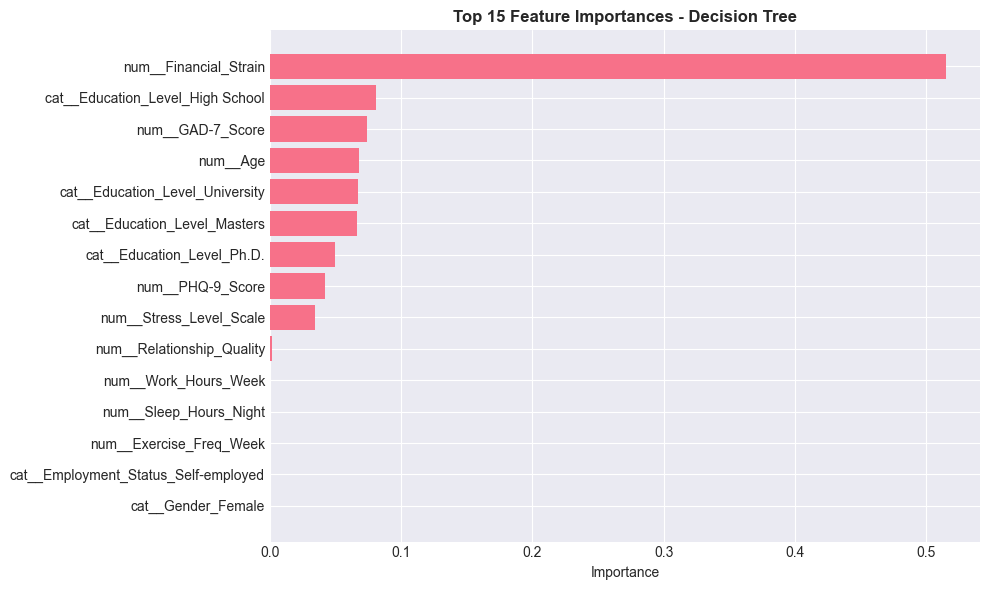

In [15]:
dt = DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=RANDOM_STATE
    )
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

dt_accuracy = accuracy_score(y_test, dt_pred)
dt_f1 = f1_score(y_test, dt_pred, average='weighted')

print(f"\nDecision Tree Results:")
print(f"  Accuracy: {dt_accuracy:.4f}")
print(f"  F1-Score (weighted): {dt_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, dt_pred, target_names=[str(c) for c in target_classes]))

model_results['Decision Tree'] = {
    'Accuracy': dt_accuracy,
    'F1-Score': dt_f1,
    'Model': dt
    }

cm_dt = confusion_matrix(y_test, dt_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_classes, yticklabels=target_classes, ax=ax)
ax.set_title('Confusion Matrix - Decision Tree', fontweight='bold')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

feature_importance_dt = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(feature_importance_dt['Feature'], feature_importance_dt['Importance'])
ax.set_xlabel('Importance')
ax.set_title('Top 15 Feature Importances - Decision Tree', fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 8.2 RANDOM FOREST


Random Forest Results:
  Accuracy: 0.9561
  F1-Score (weighted): 0.9564

Classification Report:
              precision    recall  f1-score   support

        High       0.87      0.87      0.87       809
         Low       0.98      0.97      0.98     11031
      Medium       0.88      0.91      0.90      3160

    accuracy                           0.96     15000
   macro avg       0.91      0.92      0.92     15000
weighted avg       0.96      0.96      0.96     15000



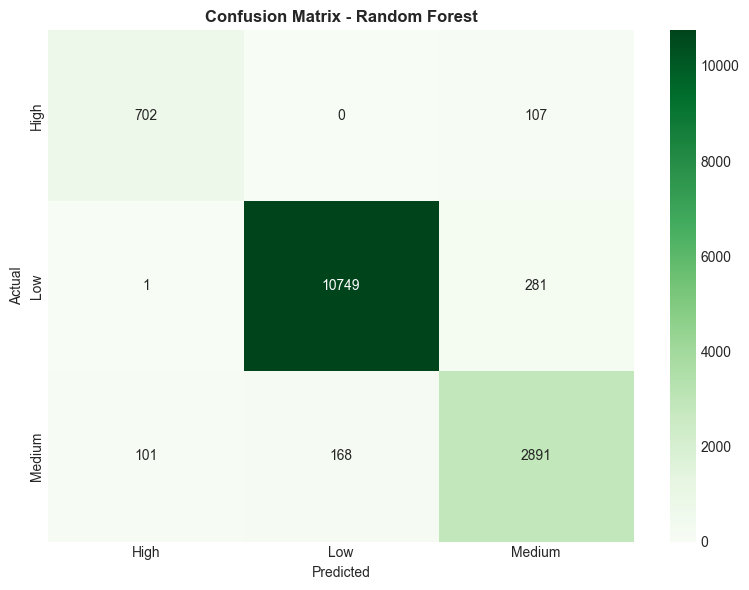

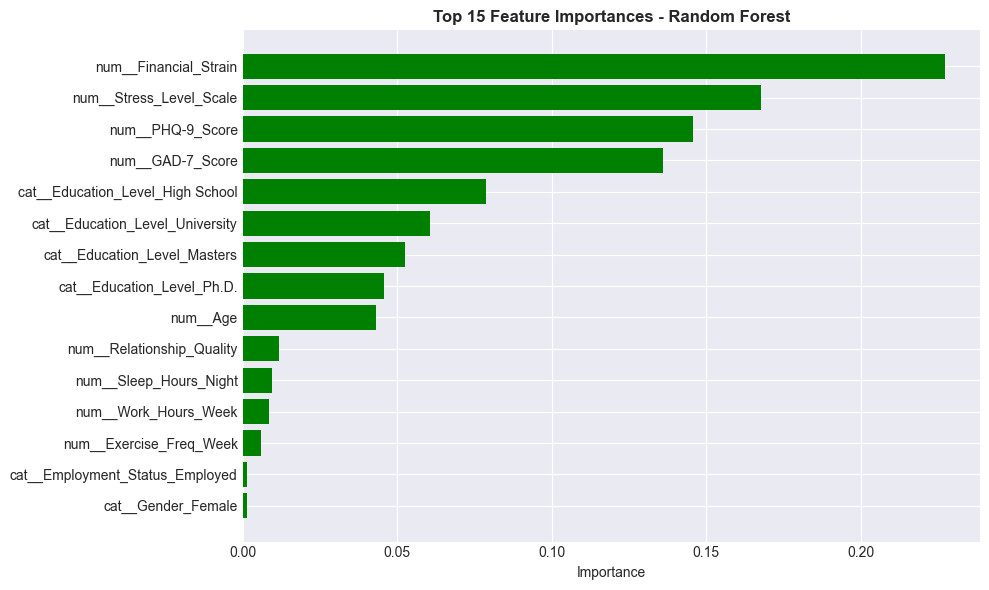

In [16]:
rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average='weighted')

print(f"\nRandom Forest Results:")
print(f"  Accuracy: {rf_accuracy:.4f}")
print(f"  F1-Score (weighted): {rf_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred, target_names=[str(c) for c in target_classes]))

model_results['Random Forest'] = {
    'Accuracy': rf_accuracy,
    'F1-Score': rf_f1,
    'Model': rf
}

cm_rf = confusion_matrix(y_test, rf_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_classes, yticklabels=target_classes, ax=ax)
ax.set_title('Confusion Matrix - Random Forest', fontweight='bold')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

feature_importance_rf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(feature_importance_rf['Feature'], feature_importance_rf['Importance'], color='green')
ax.set_xlabel('Importance')
ax.set_title('Top 15 Feature Importances - Random Forest', fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 8.3: SVM

Using stratified subset (10,000 samples) for SVM training due to computational cost...

SVM Results:
  Accuracy: 0.9454
  F1-Score (weighted): 0.9455

Classification Report:
              precision    recall  f1-score   support

        High       0.84      0.83      0.84       809
         Low       0.98      0.97      0.97     11031
      Medium       0.87      0.88      0.87      3160

    accuracy                           0.95     15000
   macro avg       0.90      0.89      0.89     15000
weighted avg       0.95      0.95      0.95     15000



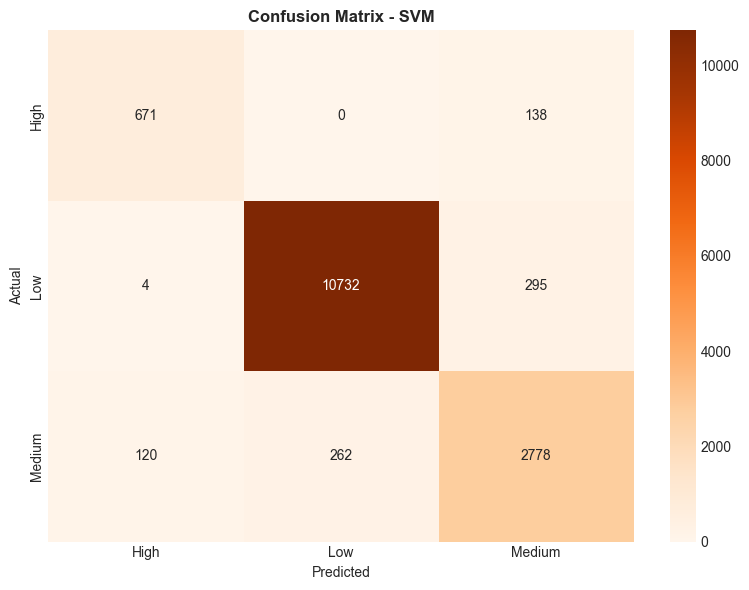

In [17]:
if len(X_train) > 10000:
    print("Using stratified subset (10,000 samples) for SVM training due to computational cost...")
    X_train_svm, _, y_train_svm, _ = train_test_split(
        X_train, y_train,
        train_size=10000,
        random_state=RANDOM_STATE,
        stratify=y_train
    )
else:
    X_train_svm = X_train
    y_train_svm = y_train

svm = SVC(
    C=10,
    gamma='scale',
    kernel='rbf',
    random_state=RANDOM_STATE
)
svm.fit(X_train_svm, y_train_svm)
svm_pred = svm.predict(X_test)

svm_accuracy = accuracy_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred, average='weighted')

print(f"\nSVM Results:")
print(f"  Accuracy: {svm_accuracy:.4f}")
print(f"  F1-Score (weighted): {svm_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, svm_pred, target_names=[str(c) for c in target_classes]))

model_results['SVM'] = {
    'Accuracy': svm_accuracy,
    'F1-Score': svm_f1,
    'Model': svm
}

cm_svm = confusion_matrix(y_test, svm_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=target_classes, yticklabels=target_classes, ax=ax)
ax.set_title('Confusion Matrix - SVM', fontweight='bold')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

## 8.4: XGBOOST


XGBoost Results:
  Accuracy: 0.9613
  F1-Score (weighted): 0.9616

Classification Report:
              precision    recall  f1-score   support

        High       0.88      0.89      0.89       809
         Low       0.99      0.98      0.98     11031
      Medium       0.90      0.93      0.91      3160

    accuracy                           0.96     15000
   macro avg       0.92      0.93      0.93     15000
weighted avg       0.96      0.96      0.96     15000



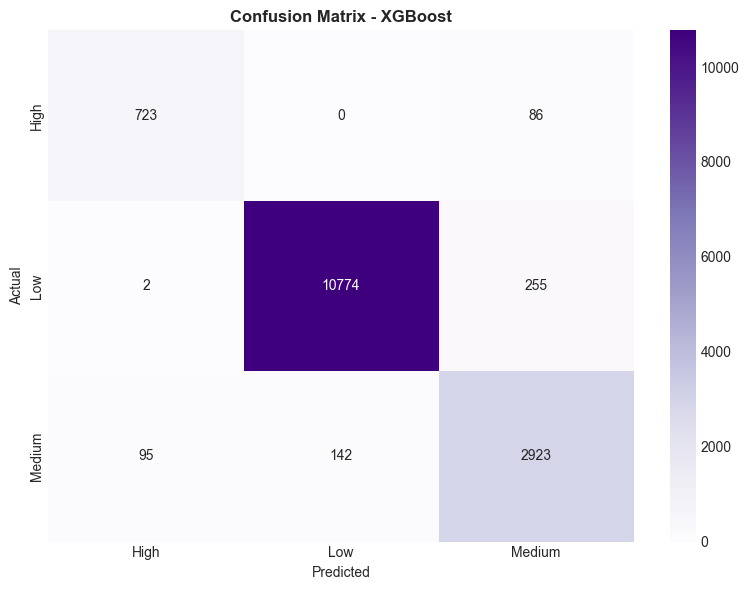

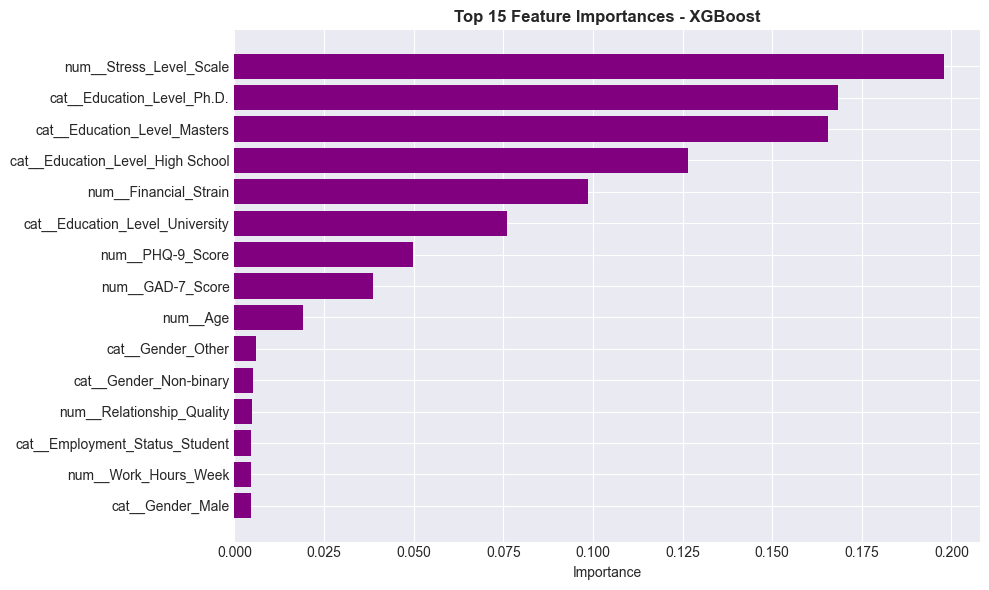

In [18]:
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric='mlogloss'
)

xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)

xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred, average='weighted')

print(f"\nXGBoost Results:")
print(f"  Accuracy: {xgb_accuracy:.4f}")
print(f"  F1-Score (weighted): {xgb_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, xgb_pred, target_names=[str(c) for c in target_classes]))

model_results['XGBoost'] = {
'Accuracy': xgb_accuracy,
'F1-Score': xgb_f1,
'Model': xgb_model
}

cm_xgb = confusion_matrix(y_test, xgb_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Purples',
        xticklabels=target_classes, yticklabels=target_classes, ax=ax)
ax.set_title('Confusion Matrix - XGBoost', fontweight='bold')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

feature_importance_xgb = pd.DataFrame({
'Feature': feature_names,
'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(feature_importance_xgb['Feature'], feature_importance_xgb['Importance'], color='purple')
ax.set_xlabel('Importance')
ax.set_title('Top 15 Feature Importances - XGBoost', fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()


## 8.5: MODEL COMPARISON


Model Performance Summary:
        Model  Accuracy  F1-Score
      XGBoost      0.96      0.96
Random Forest      0.96      0.96
Decision Tree      0.95      0.95
          SVM      0.95      0.95


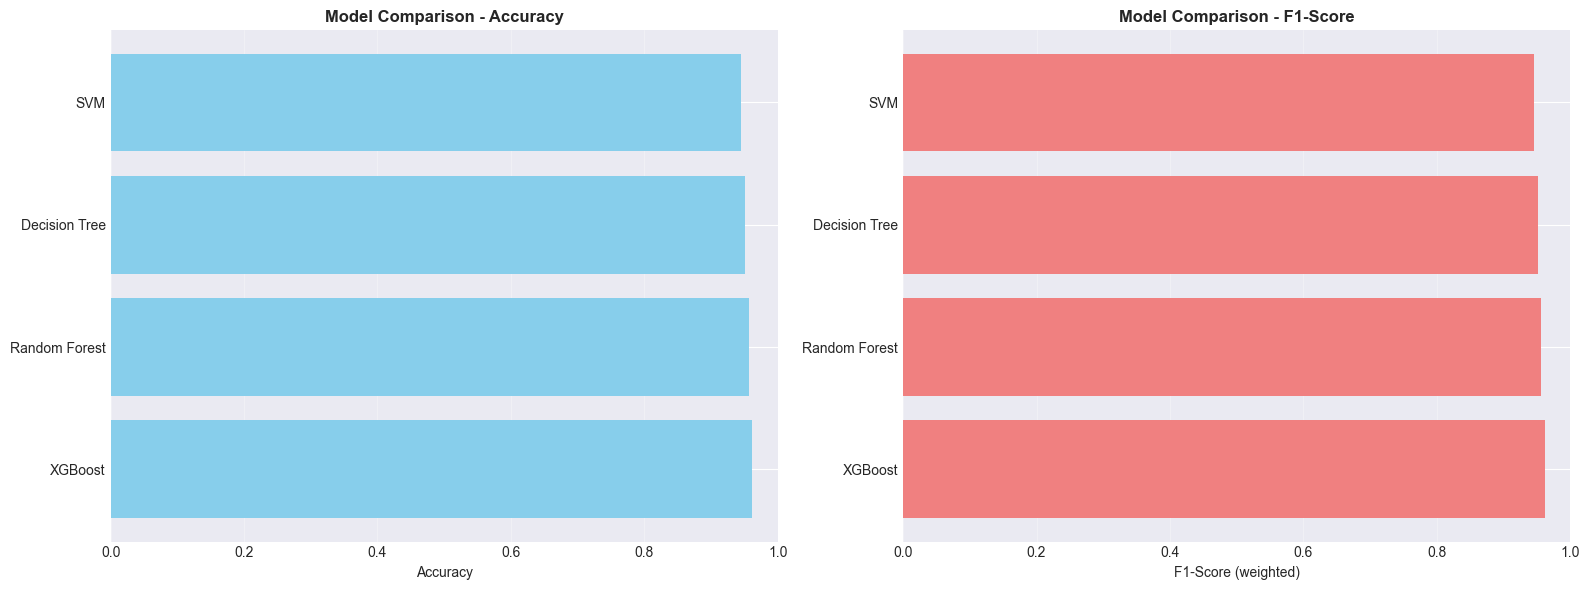


🏆 Best Model: XGBoost (Accuracy: 0.9613)


In [19]:
comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Accuracy': [model_results[m]['Accuracy'] for m in model_results],
    'F1-Score': [model_results[m]['F1-Score'] for m in model_results]
}).sort_values('Accuracy', ascending=False)

print("\nModel Performance Summary:")
print(comparison_df.to_string(index=False))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.barh(comparison_df['Model'], comparison_df['Accuracy'], color='skyblue')
ax1.set_xlabel('Accuracy')
ax1.set_title('Model Comparison - Accuracy', fontweight='bold')
ax1.set_xlim(0, 1)
ax1.grid(True, axis='x', alpha=0.3)

ax2.barh(comparison_df['Model'], comparison_df['F1-Score'], color='lightcoral')
ax2.set_xlabel('F1-Score (weighted)')
ax2.set_title('Model Comparison - F1-Score', fontweight='bold')
ax2.set_xlim(0, 1)
ax2.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

best_model_name = comparison_df.iloc[0]['Model']
best_model_acc = comparison_df.iloc[0]['Accuracy']
print(f"\n🏆 Best Model: {best_model_name} (Accuracy: {best_model_acc:.4f})")


# 9) CONCLUSION & RECOMMENDATIONS 

In [20]:
print(f"""
RÉSUMÉ DE L'ANALYSE HEALTHMIND-5
{'='*80}

1. DONNÉES
   - Dataset: {df.shape[0]:,} observations × {df.shape[1]} variables
   - Variables numériques: {len(num_cols_all)}
   - Variables catégorielles: {len(cat_cols)}
   - Duplicatas supprimés: {n_duplicates:,}

2. ANALYSE EXPLORATOIRE
   - Valeurs manquantes traitées par imputation (médiane/mode)
   - Outliers détectés par méthode IQR
   - Clipping métier appliqué selon contraintes domaine

3. CORRÉLATIONS
   - Matrice de corrélation Pearson et Spearman calculée
   - Variables fortement corrélées identifiées (|r| > 0.8)

4. RÉDUCTION DE DIMENSIONNALITÉ (PCA)
   - Composantes retenues: {n_components_80}
   - Variance cumulée: {cumulative_variance[n_components_80-1]*100:.2f}%
   - PC1 variance: {pca_final.explained_variance_ratio_[0]*100:.2f}%
   - PC2 variance: {pca_final.explained_variance_ratio_[1]*100:.2f}%

5. CLUSTERING
   - K-Means: k={best_k} clusters (Silhouette={best_silhouette:.3f})
   - DBSCAN: {n_clusters_dbscan} clusters, {n_noise} points bruit

6. CLASSIFICATION
""")

if 'Risk_Level' in df.columns and model_results:
    for model_name in comparison_df['Model']:
        acc = model_results[model_name]['Accuracy']
        f1 = model_results[model_name]['F1-Score']
        print(f"   - {model_name}: Accuracy={acc:.4f}, F1={f1:.4f}")

    print(f"""
7. RECOMMANDATIONS
   ✓ Meilleur modèle: {best_model_name} (Accuracy: {best_model_acc:.4f})
   ✓ Variables importantes: voir graphiques Feature Importance
   ✓ Clustering K-Means recommandé pour segmentation (k={best_k})

8. SUITE LOGIQUE
   - Hyperparameter tuning (GridSearchCV) pour améliorer performances
   - Validation croisée (k-fold CV) pour robustesse
   - Analyse SHAP pour explicabilité des prédictions
   - Déploiement du modèle pour prédiction en temps réel
   - Système de recommandations personnalisées basé sur profils clusters
""")
else:
    print("   (Classification non effectuée - vérifier présence Risk_Level)")

print("\n" + "=" * 80)
print("ANALYSE TERMINÉE")
print("=" * 80)

try:
    df_export = df.copy()
    df_export['KMeans_Cluster'] = kmeans_labels
    df_export['DBSCAN_Cluster'] = dbscan_labels
    df_export.to_csv('D:\codePack\OneDrive\Desktop\ProjectsClouds\MentallHealthAwareness\HealthMind_Processed_Results.csv', index=False)
except Exception as e:
    print(f"\n✗ Error saving results: {e}")



RÉSUMÉ DE L'ANALYSE HEALTHMIND-5

1. DONNÉES
   - Dataset: 75,000 observations × 13 variables
   - Variables numériques: 9
   - Variables catégorielles: 4
   - Duplicatas supprimés: 0

2. ANALYSE EXPLORATOIRE
   - Valeurs manquantes traitées par imputation (médiane/mode)
   - Outliers détectés par méthode IQR
   - Clipping métier appliqué selon contraintes domaine

3. CORRÉLATIONS
   - Matrice de corrélation Pearson et Spearman calculée
   - Variables fortement corrélées identifiées (|r| > 0.8)

4. RÉDUCTION DE DIMENSIONNALITÉ (PCA)
   - Composantes retenues: 7
   - Variance cumulée: 83.00%
   - PC1 variance: 25.36%
   - PC2 variance: 22.16%

5. CLUSTERING
   - K-Means: k=2 clusters (Silhouette=0.925)
   - DBSCAN: 21 clusters, 5667 points bruit

6. CLASSIFICATION

   - XGBoost: Accuracy=0.9613, F1=0.9616
   - Random Forest: Accuracy=0.9561, F1=0.9564
   - Decision Tree: Accuracy=0.9504, F1=0.9509
   - SVM: Accuracy=0.9454, F1=0.9455

7. RECOMMANDATIONS
   ✓ Meilleur modèle: XGBoost (A